In [ ]:
# importing necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import EfficientNet_B0_Weights

In [12]:
# Check if GPU is being recognized
torch.cuda.is_available() 

True

In [ ]:
# Define directories
train_dir = r"C:\Users\Training Data"  # Update this with the correct path
test_dir = r"C:\Users\Testing Data"  # Update this with the correct path

In [ ]:
# Define an improved data augmentation strategy
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load training and testing datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [1]:
# Load the pre-trained EfficientNet model with updated weights argument
weights = EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)

# Modify the final classification layer to match 5 output classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 5)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer with a lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate

# Implement learning rate scheduling
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

# Define a function to evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc

# Training loop setup with early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15, patience=5):
    model.train()
    
    best_val_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        # Evaluate on the test dataset
        model.eval()
        test_acc = evaluate_model(model, test_loader)

        # Adjust the learning rate
        scheduler.step(test_acc)

        # Early stopping
        if test_acc > best_val_acc:
            best_val_acc = test_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), r'transfer_learning_models/best_model.pth')  # Save the best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15, patience=5)

# Load the best model for evaluation
model.load_state_dict(torch.load(r'transfer_learning_models\best_model.pth'))
evaluate_model(model, test_loader)


C:\Users\agraw\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15, Loss: 0.8359, Accuracy: 69.70%
Test Accuracy: 86.20%
Epoch 2/15, Loss: 0.5353, Accuracy: 80.87%
Test Accuracy: 89.40%
Epoch 3/15, Loss: 0.4305, Accuracy: 84.57%
Test Accuracy: 88.40%
Epoch 4/15, Loss: 0.3988, Accuracy: 85.46%
Test Accuracy: 91.20%
Epoch 5/15, Loss: 0.3350, Accuracy: 88.19%
Test Accuracy: 91.80%
Epoch 6/15, Loss: 0.3228, Accuracy: 88.11%
Test Accuracy: 92.40%
Epoch 7/15, Loss: 0.3011, Accuracy: 89.43%
Test Accuracy: 91.60%
Epoch 8/15, Loss: 0.2725, Accuracy: 90.24%
Test Accuracy: 92.00%
Epoch 9/15, Loss: 0.2532, Accuracy: 90.98%
Test Accuracy: 92.00%
Epoch 10/15, Loss: 0.2420, Accuracy: 91.60%
Test Accuracy: 92.40%
Epoch 11/15, Loss: 0.2300, Accuracy: 91.93%
Test Accuracy: 92.40%
Early stopping at epoch 11


C:\Users\agraw\AppData\Local\Temp\ipykernel_41360\2348486268.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 92.40%


92.4

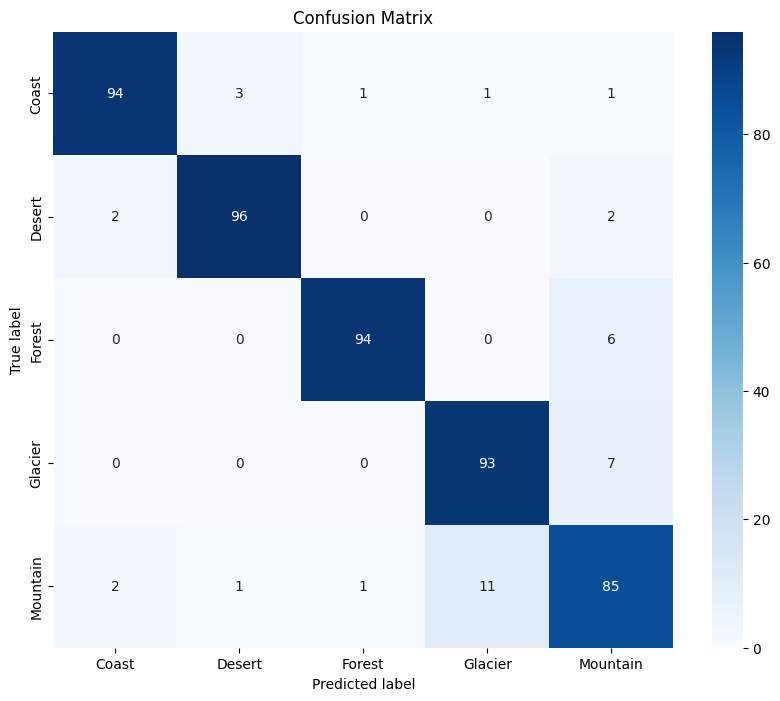

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix for the test dataset
plot_confusion_matrix(model, test_loader)


In [3]:
torch.save(model.state_dict(), 'transfer_learning_models\efficientnet_terrain_classifier.pth')


In [5]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [3]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

# Load the pre-trained model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# Modify the final classifier layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 5)

# Load the trained state dict
model.load_state_dict(torch.load('transfer_learning_models\efficientnet_terrain_classifier.pth'))

C:\Users\agraw\AppData\Local\Temp\ipykernel_30992\3960071414.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_terrain_clas

<All keys matched successfully>

### To load and test model with example image

Predicted terrain class: Coast


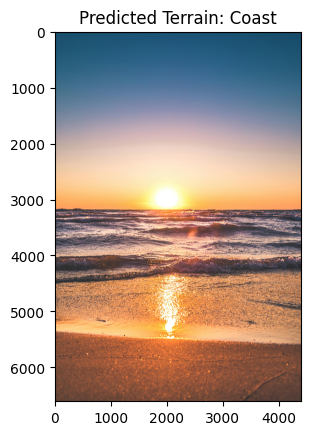

In [10]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def load_terrain_classifier(model_path):

  # Pre-trained model with weights only for security
  model = efficientnet_b0(weights=None)

  # Modify the final classifier layer
  num_ftrs = model.classifier[1].in_features
  model.classifier[1] = nn.Linear(num_ftrs, 5)

  try:
      # Load weights only for improved security
      model.load_state_dict(torch.load(model_path, map_location='cpu', weights_only=True))
  except RuntimeError as e:
      raise RuntimeError(f"Error loading model: {e}") from e

  return model

# Define the classes
classes = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

# Load the trained model
terrain_classifier = load_terrain_classifier('transfer_learning_models\efficientnet_terrain_classifier.pth')
terrain_classifier.eval()  # Set the model to evaluation mode

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of the model
    transforms.ToTensor(),           # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load and preprocess the image
def predict_image(image_path):
    image = Image.open(image_path)
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = terrain_classifier(image_tensor)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Predict the terrain class
image_path = r"path to test image"
predicted_class = predict_image(image_path)
print(f"Predicted terrain class: {classes[predicted_class]}")

# Visualize the image and prediction
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted Terrain: {classes[predicted_class]}")
plt.show()